<a href="https://colab.research.google.com/github/nickwan/nfl_timeout_value/blob/master/timeout_value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --quiet shap 

     |████████████████████████████████| 266kB 4.9MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import itertools
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import paired_distances,euclidean_distances
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.metrics import mean_squared_error, accuracy_score,pairwise_distances, log_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import shap
sns.set_context('talk')
shap.initjs()

In [0]:
file_dir = 'drive/My Drive/nfl_pbp/'
game_outcomes = pd.read_csv(f"{file_dir}games.csv")

files = [x for x in os.listdir(file_dir) if x[:7] == 'reg_pbp']
files = list(reversed(files))
df = pd.DataFrame()
for f in files:
  _df = pd.read_csv(file_dir+f, low_memory=False)
  _df['season'] = int(f[8:12])
  df = df.append(_df, ignore_index=True)

df['play_type_code'] = df['play_type'].astype('category').cat.codes
df['pass_length_code'] = df['pass_length'].astype('category').cat.codes
df['pass_location_code'] = df['pass_location'].astype('category').cat.codes
df['run_location_code'] = df['run_location'].astype('category').cat.codes
df['run_gap_code'] = df['run_gap'].astype('category').cat.codes

df.loc[:,['shotgun','no_huddle', 'qb_dropback', 'qb_kneel', 
          'qb_spike', 'qb_scramble','pass_length_code', 'pass_location_code',
          'run_location_code', 'run_gap_code']] = df.loc[:,['shotgun','no_huddle', 'qb_dropback', 'qb_kneel', 
          'qb_spike', 'qb_scramble','pass_length_code', 'pass_location_code',
          'run_location_code', 'run_gap_code']].fillna(-1).astype(int)

df['is_success'] = 0
df.loc[(df['down']==1)&(df['yards_gained'] >= df['ydstogo'].mul(.5)),'is_success'] = 1
df.loc[(df['down']==2)&(df['yards_gained'] >= df['ydstogo'].mul(.8)),'is_success'] = 1
df.loc[(df['down'].isin([3,4]))&(df['yards_gained'] >= df['ydstogo']),'is_success'] = 1

# bins for field positioning
field_pos_bins = np.arange(0,101,20)
for pos_start, pos_end in zip(field_pos_bins[:-1],field_pos_bins[1:]):  
  df.loc[df['yardline_100'].between(pos_start, pos_end),'field_pos'] = pos_end  

game_outcomes = game_outcomes.loc[game_outcomes['result']!=0]
game_outcomes['home_win'] = 0
game_outcomes.loc[game_outcomes['result']>0,'home_win'] = 1 

df = df.merge(game_outcomes.loc[:,['game_id','home_win']])
df['posteam_win'] = df['home_win']
df.loc[df['home_team']!=df['posteam'],'posteam_win'] = df.loc[df['home_team']!=df['posteam'],'posteam_win'].replace([0,1],[1,0])

df.shape  

(496614, 266)

In [0]:
df.loc[df['down'].isnull(),'ydstogo'] = np.nan
df['down'] = df['down'].fillna(method='bfill')
df['ydstogo'] = df['ydstogo'].fillna(method='bfill')

# VARIABLE NAMES  
* shoot 
* nickXpurg  
* nickxpurg2  

# Value of a timeout  
What is the value of a timeout? What factors matter when calling an effective time out?? 

## Features  
* total timeouts left (timeout diff)  
* possession  
* time (seconds left, qtr, half, 2-min)  
* score (score diff)  
* variability of outcome (EP, WP, EPA, WPA)  
* home field advantage?  
* situation (down, dist, ydstogo, field pos)  
* previous play success (assuming cumulative "carry over" effects?)  

* if something is "replayable"?  
'replay_or_challenge', 'replay_or_challenge_result'


## Does "slowing down" the offense help?  
Does calling timeout on a hurry up/no huddle offense help the defense? 


## Previous work  
>  yard line, score difference, time remaining, and timeouts for the offense and defense as predictors

http://archive.advancedfootballanalytics.com/2014/01/the-value-of-timeout-part-2.html

In [0]:
model_feats = ['posteam_timeouts_remaining','defteam_timeouts_remaining',
               'game_half','time','qtr', 'down','yrdln', 'ydstogo',
               'home_timeouts_remaining', 'away_timeouts_remaining', 'penalty',
               'timeout','timeout_team','posteam_timeouts_remaining',
               'defteam_timeouts_remaining', 'total_home_score',
               'total_away_score', 'posteam_score', 'defteam_score',
               'score_differential', 'no_score_prob', 'opp_fg_prob',
               'opp_safety_prob', 'opp_td_prob', 'fg_prob', 'safety_prob',
               'td_prob', 'extra_point_prob', 'two_point_conversion_prob', 'ep',
               'epa','wp', 'def_wp', 'home_wp', 'away_wp','wpa']

In [0]:
df_timeout = df.loc[df['timeout']==1]
df_timeout.shape

(20604, 266)

In [0]:
df.loc[28:32,'desc']

28    (3:13) (Shotgun) M.Davis right guard to CHI 5 ...
29    (2:32) (Shotgun) M.Trubisky pass short middle ...
30                          Timeout #1 by CHI at 01:50.
31    (1:50) (Shotgun) M.Trubisky pass incomplete sh...
32    (1:46) (Shotgun) M.Trubisky pass short middle ...
Name: desc, dtype: object

In [0]:
df.loc[28:32,['desc','down','ydstogo', 'time', 
              'quarter_seconds_remaining', 
              'half_seconds_remaining']]
              

,desc,down,ydstogo,time,quarter_seconds_remaining,half_seconds_remaining
28,(3:13) (Shotgun) M.Davis right guard to CHI 5 ...,1.0,10.0,03:13,193.0,1093.0
29,(2:32) (Shotgun) M.Trubisky pass short middle ...,2.0,9.0,02:32,152.0,1052.0
30,Timeout #1 by CHI at 01:50.,3.0,4.0,01:50,110.0,1010.0
31,(1:50) (Shotgun) M.Trubisky pass incomplete sh...,3.0,4.0,01:50,110.0,1010.0
32,(1:46) (Shotgun) M.Trubisky pass short middle ...,1.0,10.0,01:46,106.0,1006.0


In [0]:
# yard line, score difference, time remaining, and timeouts for the offense and defense as predictors

df_timeout['posteam_to'] = 0
df_timeout.loc[df_timeout['timeout_team']==df_timeout['posteam'],'posteam_to'] = 1

model_feats = ['posteam_to', 'score_differential', 
              'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 
              'half_seconds_remaining', 'yardline_100']
target = 'posteam_win'
model_data = df_timeout.loc[:,model_feats+[target]] 
model_data.loc[model_data['posteam_to']==0,'score_differential'] = model_data.loc[model_data['posteam_to']==0,'score_differential'].mul(-1)
model_data.loc[model_data['posteam_to']==0,'yardline_100'] = model_data.loc[model_data['posteam_to']==0,'yardline_100'].mul(-1).add(100)
model_data = model_data.dropna()
model_data.shape


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(20172, 7)

In [0]:
test_data = model_data.sample(frac=0.2)
train_data = model_data.loc[~model_data.index.isin(test_data.index.values)]
print(f"train: {train_data.shape}\ntest: {test_data.shape}")

train: (16138, 7)
test: (4034, 7)


In [0]:
model = LogisticRegression(max_iter=500)
model.fit(train_data.loc[:,model_feats],train_data[target])
test_data['pred'] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]),index=test_data.index)[1]

In [0]:
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats])
shap_values = explainer.shap_values(test_data.loc[:,model_feats])

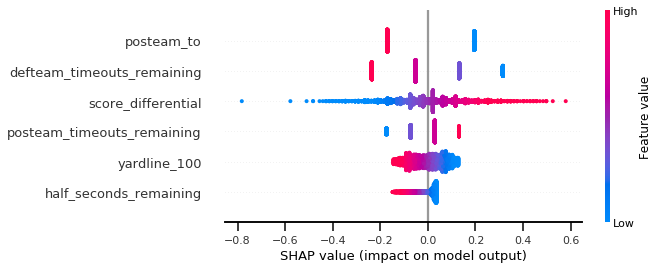

In [0]:
shap.summary_plot(shap_values, test_data.loc[:,model_feats], feature_names=model_feats)

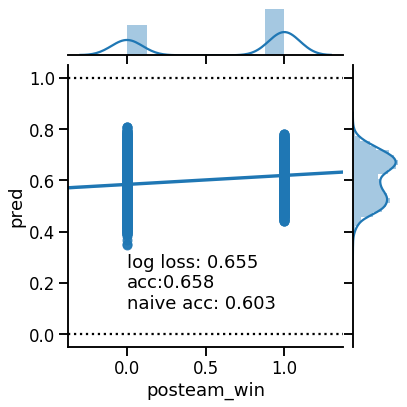

In [0]:
logloss = log_loss(test_data[target],test_data['pred'])
acc = accuracy_score(test_data[target],test_data['pred'].round(0))
mean_acc = accuracy_score(test_data[target],np.repeat([1],test_data.shape[0]))

sns.jointplot(target,'pred',data=test_data,kind='reg')
plt.text(0,0.2,f"log loss: {round(logloss,3)}\nacc:{round(acc,3)}\nnaive acc: {round(mean_acc,3)}",va='center')
plt.axhline(1,c='k',ls=':')
plt.axhline(0,c='k',ls=':')

In [0]:
model_feats = ['score_differential', 
              'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 
              'half_seconds_remaining', 'yardline_100']
model = LogisticRegression(max_iter=500)
model.fit(train_data.loc[:,model_feats],train_data[target])
test_data['pred'] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]),index=test_data.index)[1]


In [0]:
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats])
shap_values = explainer.shap_values(test_data.loc[:,model_feats])

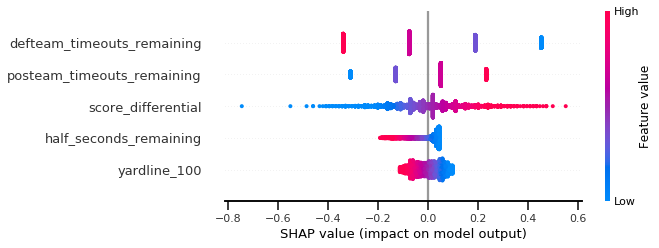

In [0]:
shap.summary_plot(shap_values, test_data.loc[:,model_feats], feature_names=model_feats)

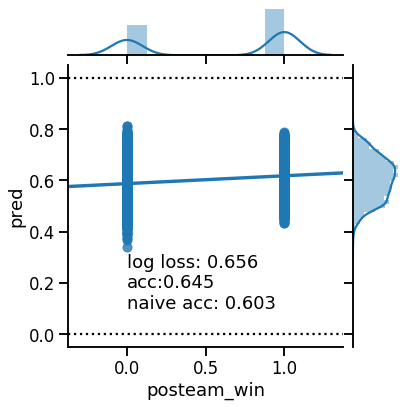

In [0]:
logloss = log_loss(test_data[target],test_data['pred'])
acc = accuracy_score(test_data[target],test_data['pred'].round(0))
mean_acc = accuracy_score(test_data[target],np.repeat([1],test_data.shape[0]))

sns.jointplot(target,'pred',data=test_data,kind='reg')
plt.text(0,0.2,f"log loss: {round(logloss,3)}\nacc:{round(acc,3)}\nnaive acc: {round(mean_acc,3)}",va='center')
plt.axhline(1,c='k',ls=':')
plt.axhline(0,c='k',ls=':')

In [0]:
model_feats = ['posteam_to', 'score_differential', 
              'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 
              'half_seconds_remaining', 'yardline_100']
target = 'posteam_win'
model = RandomForestClassifier(n_estimators=100)
model.fit(train_data.loc[:,model_feats],train_data[target])
test_data['pred'] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]),index=test_data.index)[1]

In [0]:
explainer = shap.TreeExplainer(model, train_data.loc[:,model_feats].sample(100))
shap_values = explainer.shap_values(test_data.loc[:,model_feats])

100%|===================| 8066/8068 [07:58<00:00]       

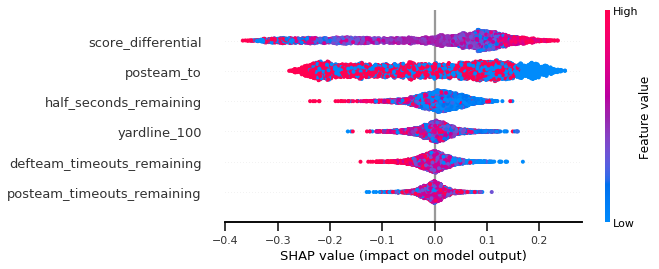

In [0]:
shap.summary_plot(shap_values[1], test_data.loc[:,model_feats], feature_names=model_feats)

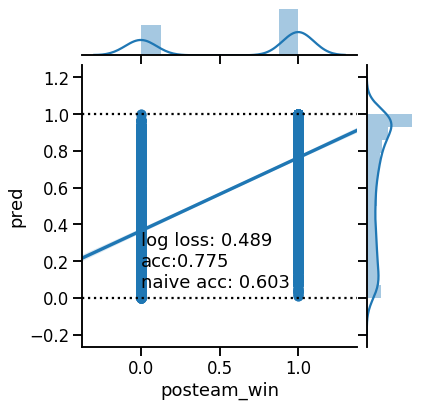

In [0]:
logloss = log_loss(test_data[target],test_data['pred'])
acc = accuracy_score(test_data[target],test_data['pred'].round(0))
mean_acc = accuracy_score(test_data[target],np.repeat([1],test_data.shape[0]))

sns.jointplot(target,'pred',data=test_data,kind='reg')
plt.text(0,0.2,f"log loss: {round(logloss,3)}\nacc:{round(acc,3)}\nnaive acc: {round(mean_acc,3)}",va='center')
plt.axhline(1,c='k',ls=':')
plt.axhline(0,c='k',ls=':')

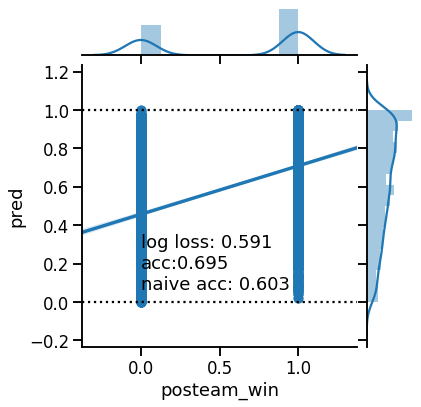

In [0]:
model_feats = ['score_differential', 
              'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 
              'half_seconds_remaining', 'yardline_100']
target = 'posteam_win'
model = RandomForestClassifier(n_estimators=100)
model.fit(train_data.loc[:,model_feats],train_data[target])
test_data['pred'] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]),index=test_data.index)[1]

logloss = log_loss(test_data[target],test_data['pred'])
acc = accuracy_score(test_data[target],test_data['pred'].round(0))
mean_acc = accuracy_score(test_data[target],np.repeat([1],test_data.shape[0]))

sns.jointplot(target,'pred',data=test_data,kind='reg')
plt.text(0,0.2,f"log loss: {round(logloss,3)}\nacc:{round(acc,3)}\nnaive acc: {round(mean_acc,3)}",va='center')
plt.axhline(1,c='k',ls=':')
plt.axhline(0,c='k',ls=':')

In [0]:
model_feats = ['posteam_to', 'score_differential', 
              'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 
              'half_seconds_remaining', 'yardline_100']
target = 'posteam_win'
model = RandomForestClassifier(n_estimators=100)
model.fit(train_data.loc[:,model_feats],train_data[target])
test_data['pred_with'] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]),index=test_data.index)[1]

model_feats = ['score_differential', 
              'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 
              'half_seconds_remaining', 'yardline_100']
target = 'posteam_win'
model = RandomForestClassifier(n_estimators=100)
model.fit(train_data.loc[:,model_feats],train_data[target])
test_data['pred_without'] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]),index=test_data.index)[1]

In [0]:
test_data['to_effect'] = test_data['pred_with'].sub(test_data['pred_without'])
test_data['to_val'] = test_data['to_effect'].mul(33)

In [0]:
test_data = test_data.merge(df[['posteam','home_team','away_team','wp','desc']],left_index=True,right_index=True).sort_values('to_effect',ascending=False)

count    4034.000000
mean       -0.131093
std         6.396659
min       -32.670000
25%        -1.980000
50%         0.000000
75%         2.310000
max        25.740000
Name: to_val, dtype: float64

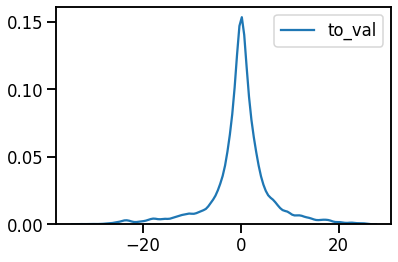

In [0]:
sns.kdeplot(test_data['to_val'])
test_data['to_val'].describe()

In [0]:
test_data.sort_values('to_val',ascending=False)

,posteam_to,score_differential,posteam_timeouts_remaining,defteam_timeouts_remaining,half_seconds_remaining,yardline_100,posteam_win,pred,pred_with,pred_without,to_effect,to_val,posteam,home_team,away_team,wp,desc
157542,0,-25.0,1.0,1.0,55.0,76.0,1,0.12,0.91,0.13,0.78,25.74,DAL,CLE,DAL,0.999859,Timeout #2 by CLE at 00:55.
461185,0,-17.0,1.0,2.0,38.0,79.0,1,0.24,0.91,0.14,0.77,25.41,JAC,JAC,TEN,0.976305,Timeout #1 by TEN at 00:38.
18094,0,-11.0,2.0,2.0,40.0,61.0,1,0.22,0.97,0.21,0.76,25.08,NO,CHI,NO,0.994201,Timeout #1 by CHI at 00:40.
278787,1,17.0,2.0,2.0,536.0,45.0,1,0.18,0.92,0.17,0.75,24.75,NO,NO,ARI,0.976371,Timeout #1 by NO at 08:56.
18361,0,-17.0,0.0,1.0,9.0,45.0,1,0.08,0.88,0.13,0.75,24.75,DAL,DAL,PHI,0.951604,Timeout #2 by PHI at 00:09.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184307,1,-16.0,2.0,2.0,268.0,63.0,0,0.89,0.04,0.88,-0.84,-27.72,DET,MIN,DET,0.026583,Timeout #1 by DET at 04:28.
270772,1,-10.0,0.0,1.0,192.0,75.0,0,0.91,0.06,0.93,-0.87,-28.71,MIA,MIA,NYJ,0.059477,Timeout #4 by MIA at 03:12.
154255,1,-15.0,2.0,1.0,283.0,66.0,0,0.97,0.07,0.98,-0.91,-30.03,HOU,DEN,HOU,0.025888,Timeout #1 by HOU at 04:43.
165877,1,-9.0,1.0,1.0,139.0,45.0,0,0.97,0.01,0.95,-0.94,-31.02,SEA,TB,SEA,0.080533,Timeout #2 by SEA at 02:19.


In [0]:
df_timeout

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,...,pass_defense_2_player_id,pass_defense_2_player_name,fumbled_1_team,fumbled_1_player_id,fumbled_1_player_name,fumbled_2_player_id,fumbled_2_player_name,fumbled_2_team,fumble_recovery_1_team,fumble_recovery_1_yards,fumble_recovery_1_player_id,fumble_recovery_1_player_name,fumble_recovery_2_team,fumble_recovery_2_yards,fumble_recovery_2_player_id,fumble_recovery_2_player_name,return_team,return_yards,penalty_team,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,season,play_type_code,pass_length_code,pass_location_code,run_location_code,run_gap_code,is_success,field_pos,home_win,posteam_win,posteam_to
30,846,2019090500,CHI,GB,CHI,home,GB,CHI,95.0,2019-09-05,110.0,1010.0,2810.0,Half1,0,6,0,1,3.0,0.0,01:50,CHI 5,4.0,25,Timeout #1 by CHI at 01:50.,no_play,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2019,3,-1,-1,-1,-1,0,100.0,0,0,1
78,2134,2019090500,CHI,GB,CHI,home,GB,CHI,84.0,2019-09-05,24.0,24.0,1824.0,Half1,0,12,0,2,4.0,0.0,00:24,CHI 16,10.0,0,Timeout #2 by GB at 00:24.,no_play,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2019,3,-1,-1,-1,-1,0,100.0,0,0,0
81,2203,2019090500,CHI,GB,GB,away,CHI,GB,67.0,2019-09-05,9.0,9.0,1809.0,Half1,0,13,0,2,1.0,0.0,00:09,GB 33,10.0,16,Timeout #3 by GB at 00:09.,no_play,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2019,3,-1,-1,-1,-1,0,80.0,0,1,1
93,2517,2019090500,CHI,GB,GB,away,CHI,CHI,35.0,2019-09-05,779.0,1679.0,1679.0,Half2,0,15,0,3,2.0,0.0,12:59,CHI 35,10.0,19,Timeout #1 by GB at 12:59.,no_play,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2019,3,-1,-1,-1,-1,0,40.0,0,1,1
126,3389,2019090500,CHI,GB,CHI,home,GB,CHI,58.0,2019-09-05,865.0,865.0,865.0,Half2,0,20,0,4,1.0,0.0,14:25,CHI 42,10.0,23,(14:25) M.Trubisky pass short right to T.Gabri...,pass,15.0,0,0,1,0,0,0,short,right,15.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1,upheld,NaN,0.0,0.0,0.0,0.0,2019,4,1,2,-1,-1,1,60.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496492,913,2010010308,NYJ,CIN,NYJ,home,CIN,CIN,1.0,2010-01-03,818.0,818.0,2618.0,Half1,0,3,0,2,3.0,1.0,13:38,CIN 1,2.0,74,Timeout #2 by NYJ at 13:38.,no_play,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2009,3,-1,-1,-1,-1,0,20.0,1,1,1
496498,1045,2010010308,NYJ,CIN,CIN,away,NYJ,CIN,73.0,2010-01-03,755.0,755.0,2555.0,Half1,0,4,0,2,3.0,0.0,12:35,CIN 27,13.0,-3,Timeout #2 by CIN at 12:35.,no_play,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2009,3,-1,-1

In [0]:
kf = KFold(10)
df_pred = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  target = 'posteam_win'

  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  
  model_feats = ['posteam_to', 'score_differential', 
                'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 
                'half_seconds_remaining', 'yardline_100']
  
  model = RandomForestClassifier(n_estimators=100)
  model.fit(train_data.loc[:,model_feats],train_data[target])
  test_data['pred_with'] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]),index=test_data.index)[1]

  model_feats = ['score_differential', 
                'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 
                'half_seconds_remaining', 'yardline_100']
  model = RandomForestClassifier(n_estimators=100)
  model.fit(train_data.loc[:,model_feats],train_data[target])
  test_data['pred_without'] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]),index=test_data.index)[1]
  df_pred = df_pred.append(test_data)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user

In [0]:
df_pred['to_effect'] = df_pred['pred_with'].sub(df_pred['pred_without'])

In [0]:
test_data = df_pred.sample(frac=.2)
train_data = df_pred.loc[~df_pred.index.isin(test_data.index.values)]

model_feats = ['score_differential', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining', 'half_seconds_remaining',
       'yardline_100']

target = 'to_effect'

model = RandomForestRegressor(n_estimators=500)
model.fit(train_data.loc[:,model_feats],train_data[target])
test_data['pred'] = pd.Series(model.predict(test_data.loc[:,model_feats]),index=test_data.index)

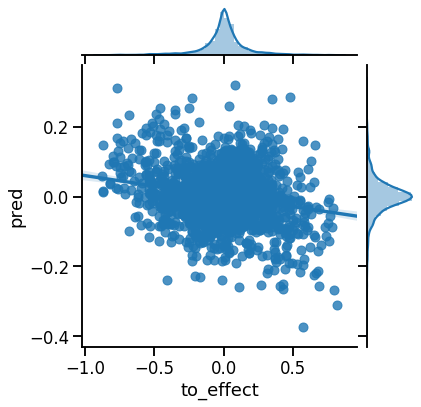

In [0]:
sns.jointplot(target,'pred',data=test_data,kind='reg')

In [0]:
model_feats = ['score_differential', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining', 'half_seconds_remaining',
       'yardline_100']

target = 'to_effect'

model = RandomForestRegressor(n_estimators=500)
model.fit(df_pred.loc[:,model_feats],df_pred[target])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
_df = df.loc[:,model_feats].dropna()
_df['to_effect'] = pd.Series(model.predict(_df),index=_df.index)

In [0]:
df['to_effect'] = _df['to_effect']
df['to_value'] = df['to_effect']
df.loc[(df['posteam']!=df['timeout_team'])&(df['timeout_team'].notnull()),'to_value'] = df.loc[(df['posteam']!=df['timeout_team'])&(df['timeout_team'].notnull()),'to_value'].mul(-1)

In [132]:
df_to_effect = df.loc[df['timeout']==1,['posteam','season','to_effect']].groupby(['posteam','season'],as_index=False).sum()
_df = df.loc[df['timeout']==1,['posteam','season','to_effect']].groupby(['posteam','season'],as_index=False).count()
df_to_effect = df_to_effect.merge(_df.rename(columns={'to_effect':'n_to'}))
df_to_effect['to_val_rate'] = df_to_effect['to_effect'].div(df_to_effect['n_to'])
df_to_effect.shape

(353, 5)

count    353.000000
mean      -0.167576
std        0.895682
min       -2.451545
25%       -0.784047
50%       -0.212564
75%        0.464199
max        2.699265
Name: to_effect, dtype: float64

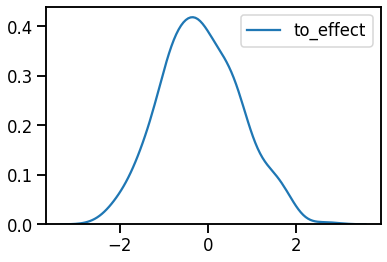

In [0]:
sns.kdeplot(df_to_effect['to_effect'])
df_to_effect['to_effect'].describe()

In [0]:
df_to_effect.sort_values('to_effect',ascending=False).head(10)

,posteam,season,to_effect
219,NO,2011,2.699265
206,NE,2009,1.925900
123,GB,2011,1.830644
306,SF,2013,1.803260
304,SF,2011,1.797015
217,NO,2009,1.724677
221,NO,2013,1.708839
122,GB,2010,1.706727
227,NO,2019,1.698704
50,CAR,2015,1.671063


In [0]:
df_to_effect.sort_values('to_effect',ascending=False).tail(10)

,posteam,season,to_effect
177,LA,2016,-1.848164
139,HOU,2016,-1.888921
344,WAS,2011,-1.938529
35,BUF,2011,-1.977217
84,CLE,2016,-2.008150
86,CLE,2018,-2.013091
247,NYJ,2017,-2.134094
193,MIA,2018,-2.141502
169,KC,2012,-2.188386
310,SF,2017,-2.451545


count    353.000000
mean      -0.003462
std        0.015621
min       -0.040526
25%       -0.014344
50%       -0.004117
75%        0.007955
max        0.036477
Name: to_val_rate, dtype: float64

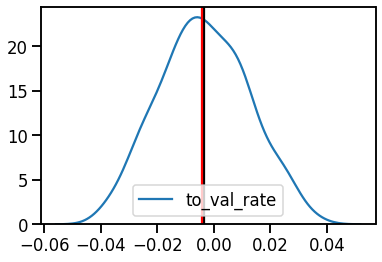

In [0]:
sns.kdeplot(df_to_effect['to_val_rate'])
plt.axvline(df_to_effect['to_val_rate'].mean(),c='k')
plt.axvline(df_to_effect['to_val_rate'].median(),c='r')
df_to_effect['to_val_rate'].describe()

In [0]:
df_to_effect.sort_values('to_val_rate',ascending=False).head(10)

,posteam,season,to_effect,n_to,to_val_rate
219,NO,2011,2.699265,74,0.036477
32,BAL,2019,1.560405,46,0.033922
212,NE,2015,1.625749,49,0.033179
161,JAC,2016,0.215179,7,0.030740
227,NO,2019,1.698704,60,0.028312
6,ARI,2015,1.506096,54,0.027891
122,GB,2010,1.706727,62,0.027528
93,DAL,2014,1.632583,60,0.027210
206,NE,2009,1.925900,71,0.027125
209,NE,2012,1.226199,47,0.026089


In [0]:
df_to_effect.sort_values('to_val_rate',ascending=False).tail(10)

,posteam,season,to_effect,n_to,to_val_rate
67,CIN,2010,-1.782441,55,-0.032408
35,BUF,2011,-1.977217,60,-0.032954
86,CLE,2018,-2.013091,59,-0.034120
45,CAR,2010,-1.523970,43,-0.035441
310,SF,2017,-2.451545,69,-0.035530
177,LA,2016,-1.848164,51,-0.036239
247,NYJ,2017,-2.134094,58,-0.036795
84,CLE,2016,-2.008150,54,-0.037188
193,MIA,2018,-2.141502,57,-0.037570
169,KC,2012,-2.188386,54,-0.040526


In [0]:
_df.loc[25864,'desc']

'(13:11) (Shotgun) E.Elliott left tackle to MIN 35 for 5 yards (D.Hunter).'

In [0]:
_df.loc[_df['timeout']==1,['posteam','timeout_team','to_value']]

,posteam,timeout_team,to_value
25762,MIN,MIN,-0.029960
25810,MIN,MIN,0.061880
25814,MIN,MIN,0.009634
25896,DAL,MIN,0.034460
25899,MIN,DAL,0.068055
25901,MIN,DAL,0.042935
25903,MIN,DAL,0.027896


TO value logic:  
$\text{TO value}=\sum{}\text{TO_value}_{pos} - \sum{}\text{TO_value}_{def} - \sum{}\text{TO_value}_{pos not taken}$ 

things to consider:
weights per sum? calling a timeout might be worth more?  



In [134]:
df_game_to_val = pd.DataFrame()
for gid in df['game_id'].unique():
  _df = df.loc[df['game_id']==gid]
  _df['game_to_val'] = np.nan
  _teams = _df.loc[_df['posteam'].notnull(),'posteam'].unique()
  for team in _teams:
    _to_val_pos = _df.loc[(_df['posteam']==team)&(_df['timeout_team']==team),'to_value'].sum()
    _to_val_def = _df.loc[(_df['posteam']==team)&(_df['timeout_team']!=team)&(_df['timeout_team'].notnull()),'to_value'].sum()
    _to_val_pos_min = _df.loc[(_df['posteam']==team)&(_df['timeout_team']==team),'to_value'].min()

    if np.isnan(_to_val_pos_min):
      _to_val_pos_min = 0

    _to_val_not_taken = _df.loc[(_df['posteam']==team)&(_df['timeout']==0)&(_df['posteam_timeouts_remaining']>0)&(_df['to_value']>_to_val_pos_min),'to_value'].sum()

    game_to_val = _to_val_pos-_to_val_def-_to_val_not_taken

    _df.loc[_df['posteam']==team,'game_to_val'] = game_to_val

    df_game_to_val = df_game_to_val.append(_df.loc[:,['game_id','season','posteam','game_to_val']].drop_duplicates(),ignore_index=True)

df_game_to_val = df_game_to_val.dropna().drop_duplicates()    


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


count    5616.000000
mean       -0.488585
std         0.574658
min        -6.515848
25%        -0.787343
50%        -0.480315
75%        -0.113144
max         2.286556
Name: game_to_val, dtype: float64

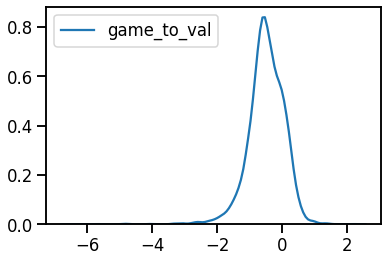

In [143]:
sns.kdeplot(df_game_to_val['game_to_val'])
df_game_to_val['game_to_val'].describe()

count    159.000000
mean      -0.489159
std        0.537223
min       -3.150240
25%       -0.724401
50%       -0.433757
75%       -0.142402
max        0.698845
Name: game_to_val, dtype: float64

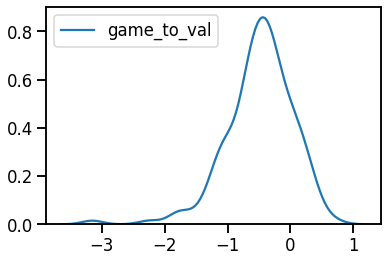

In [144]:
sns.kdeplot(df_game_to_val.loc[(df_game_to_val['posteam']=='SEA')&(df_game_to_val['season']>=2010),'game_to_val'])
df_game_to_val.loc[(df_game_to_val['posteam']=='SEA')&(df_game_to_val['season']>=2010),'game_to_val'].describe()

count    160.000000
mean      -0.427358
std        0.517337
min       -2.015729
25%       -0.736845
50%       -0.433404
75%       -0.105896
max        0.750338
Name: game_to_val, dtype: float64

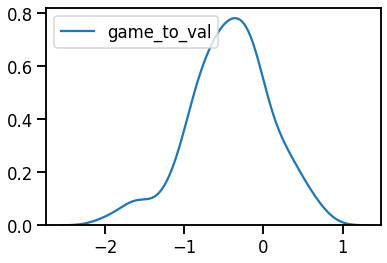

In [146]:
sns.kdeplot(df_game_to_val.loc[(df_game_to_val['posteam']=='BAL')&(df_game_to_val['season']>=2010),'game_to_val'])
df_game_to_val.loc[(df_game_to_val['posteam']=='BAL')&(df_game_to_val['season']>=2010),'game_to_val'].describe()

count    160.000000
mean      -0.413429
std        0.484637
min       -2.159340
25%       -0.719248
50%       -0.359449
75%       -0.047749
max        0.725471
Name: game_to_val, dtype: float64

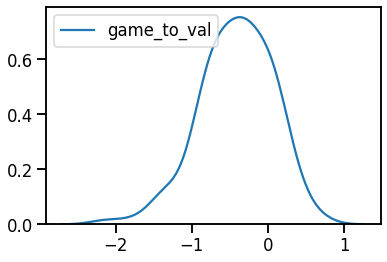

In [158]:
sns.kdeplot(df_game_to_val.loc[((df_game_to_val['posteam']=='PHI')&(df_game_to_val['season'].between(2010,2012)))|((df_game_to_val['posteam']=='KC')&(df_game_to_val['season']>=2013)),'game_to_val'])
df_game_to_val.loc[((df_game_to_val['posteam']=='PHI')&(df_game_to_val['season'].between(2010,2012)))|((df_game_to_val['posteam']=='KC')&(df_game_to_val['season']>=2013)),'game_to_val'].describe()

In [159]:
df_game_to_val.head()

,game_id,season,posteam,game_to_val
0,2019090500,2019,GB,-0.137791
4,2019090500,2019,CHI,-0.558755
6,2019090800,2019,CAR,-0.016531
10,2019090800,2019,LA,-0.842108
12,2019090806,2019,WAS,-0.562759


In [167]:
df_game_to_val_agg = df_game_to_val.loc[:,['season','posteam','game_to_val']].groupby(['season','posteam'],as_index=False).mean()
df_game_to_val_agg = df_game_to_val_agg.merge(df_game_to_val.loc[:,['season','posteam','game_to_val']].groupby(['season','posteam']).std().reset_index().rename(columns={'game_to_val':'game_to_val_sd'}))
df_game_to_val_agg

,season,posteam,game_to_val,game_to_val_sd
0,2009,ARI,-0.608249,0.562193
1,2009,ATL,-0.485769,0.538850
2,2009,BAL,-0.669263,0.636298
3,2009,BUF,-0.486720,0.412425
4,2009,CAR,-0.386565,0.408841
...,...,...,...,...
348,2019,SEA,-0.329983,0.495175
349,2019,SF,-0.298978,0.511338
350,2019,TB,-0.525857,0.451769
351,2019,TEN,-0.580713,0.355019


count    353.000000
mean      -0.488080
std        0.145526
min       -1.056640
25%       -0.579933
50%       -0.479646
75%       -0.390930
max       -0.122950
Name: game_to_val, dtype: float64

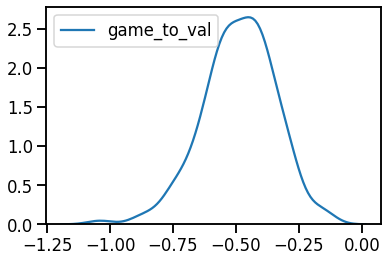

In [168]:
sns.kdeplot(df_game_to_val_agg['game_to_val'])
df_game_to_val_agg['game_to_val'].describe()

invalid value encountered in greater
invalid value encountered in less


count    352.000000
mean       0.545538
std        0.179099
min        0.211040
25%        0.432278
50%        0.515354
75%        0.604691
max        1.612234
Name: game_to_val_sd, dtype: float64

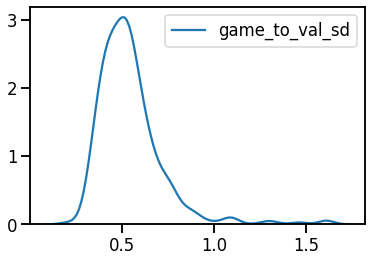

In [169]:
sns.kdeplot(df_game_to_val_agg['game_to_val_sd'])
df_game_to_val_agg['game_to_val_sd'].describe()

In [170]:
df_game_to_val_agg.sort_values('game_to_val',ascending=False).head(10)

,season,posteam,game_to_val,game_to_val_sd
177,2014,MIN,-0.122950,0.582820
76,2011,HOU,-0.131820,0.475150
247,2016,NYJ,-0.148329,0.520952
120,2012,PIT,-0.164064,0.484126
162,2014,BAL,-0.174600,0.436843
133,2013,CHI,-0.174683,0.756767
296,2018,CLE,-0.175781,0.505758
106,2012,DET,-0.187332,0.574813
37,2010,CHI,-0.232031,0.416725
152,2013,PIT,-0.233714,0.404693


In [171]:
df_game_to_val_agg.sort_values('game_to_val',ascending=False).tail(10)

,season,posteam,game_to_val,game_to_val_sd
126,2012,TEN,-0.773531,1.279332
182,2014,OAK,-0.804157,1.463370
30,2009,TEN,-0.809302,1.320781
142,2013,JAC,-0.828971,0.744190
135,2013,CLE,-0.847092,0.826006
20,2009,NYG,-0.871126,0.746895
151,2013,PHI,-0.871614,0.590797
96,2012,ARI,-0.902115,1.093843
189,2014,TB,-1.022509,1.608016
184,2014,PIT,-1.056640,1.078828


# Final Thoughts  
I think it is possible to quantify the value of a timeout on a play-by-play level. I believe the model built here and the resulting math to quantify the value of a timeout over the course of a game points in an intuitive direction. The preliminary, general results indicate teams are not optimal at calling timeouts and the value of a time out over the course of a game can be worth (at most) up to half of the win probability (and more likely, worth ~1% of the win probability).  

The model itself is bad and inaccurate. Although it was based on previous research (see: http://archive.advancedfootballanalytics.com/2014/01/the-value-of-timeout-part-2.html) and the advancements made here were perhaps more accurate than the previous works, the value of a timeout on the play-by-play level is very noisy and at times illogical (returning values worth more than what the game is worth). Making this model more accurate with more comprehensive features (and perhaps a stronger target dependent variable than win/loss binary) could provide even more value than the subsequent algebra that creates the "timeout value".  

The timeout value math (see above) seems also intuitive and logical, taking into account timeouts made by both teams, whether the team was in possession or on defense, and the possible timeouts a team could have taken instead of the timeouts that were actually taken. With this information together, I believe the value of a timeout over the course of a game makes for a better (read: less noisy) valuation of a timeout than a timeout that is on the play-by-play level. However, the math to create this metric is also relatively basic and could be made more accurate with weighting the values for when a timeout was taken, specifically by using remaining timeouts. Furthermore, the value of a timeout over the course of a game is a descriptive statistic -- one that perhaps is not as useful for in-game decisions as a timeout metric on the play-by-play level.  

I would suggest the next attempt to focus on the modeling aspects of the value of a timeout as opposed to the algebraic solutions to describe the value of a timeout. It is likely that you can solve for the latter by optimizing the former. It is also likely that the former, a play-by-play value for a timeout, is more valuable overall than a game-by-game metric.  

1/26/2020
